# Introduction

In this project we want to create a model that can predict the price of a diamond based on its characteristics. 

For this we are going to perform three different procedures. 
On the one hand a linear model, specifically a linear regression model. As a second model we will use an emsabled model such as RandomForest, tuning the hyperparameters with a Bayesian optimization model such as HyperOpt. And finally, we will test the Pycaret library, where we will choose the most appropriate model.

# Data

The Diamonds DataSet has been obtained from Kaggle, at the following [link](https://www.kaggle.com/shivam2503/diamonds). In it, each input is a diamond and the columns correspond to diamond characteristics.

**Predictors Variables** 

 `id`: Input ID.
 
 `carat`: diamond weight.
 
 `cut`: The way in which the diamond facets interact with light.
 
 `clarity`: Purity or transparency of a diamond.
 
 `color`: Color of a diamond.
 
 `table`: Flat part of the upper part.
 
 `x`: Length in mm.

 `y`: Width in mm.

 `z`: Depth in mm.

 `depht`:  Total depth percentage = z / mean(x, y) = 2 * z / (x + y).


**Target Variable**

`price`: Diamond price.

# Libraries

First of all, import the libraries we are going to use.

In [1]:
#import libraries

#data processing
#--------------------------------------------
import pandas as pd
import numpy as np

#graphics
#--------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
%matplotlib inline

#preprocessig
#--------------------------------------------
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split



#modelling
#--------------------------------------------
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold

#Hyperopt
#---------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

#Pycaret
#---------------------------------------------
from pycaret.regression import *


#others
#----------------------------------------------
from src.utils import unzip_zip
import warnings
warnings.filterwarnings('ignore')

# Checking Data

## First Approach

Using the `unzip_zip` function contained in `utils.py` in the folder `src`, we unzip the `.csv` files and load them into a Dataframe.

We save the DataFrames in variables.

In [2]:
#unzip and read csv
df_train = unzip_zip("data/diamonds-datamad0121.zip", "train.csv")

Now, let's check the DataFrame

In [3]:
#check data
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.50,Premium,F,VS2,61.5,58.0,7.32,7.34,4.51,9.588
1,1,2.01,Very Good,E,SI2,60.6,59.0,8.11,8.25,4.96,9.748
2,2,0.50,Ideal,E,SI1,61.6,57.0,5.13,5.09,3.15,7.255
3,3,0.25,Very Good,F,VVS2,61.6,57.0,4.05,4.08,2.50,6.450
4,4,0.52,Ideal,G,VS2,62.0,55.0,5.16,5.19,3.21,7.721


In [4]:
#check the number of columns and rows
df_train.shape

(40455, 11)

In [5]:
#check the columns
df_train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'price'],
      dtype='object')

In [6]:
#check types
df_train.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [7]:
#check data
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.50,Premium,F,VS2,61.5,58.0,7.32,7.34,4.51,9.588
1,1,2.01,Very Good,E,SI2,60.6,59.0,8.11,8.25,4.96,9.748
2,2,0.50,Ideal,E,SI1,61.6,57.0,5.13,5.09,3.15,7.255
3,3,0.25,Very Good,F,VVS2,61.6,57.0,4.05,4.08,2.50,6.450
4,4,0.52,Ideal,G,VS2,62.0,55.0,5.16,5.19,3.21,7.721


In [8]:
#check if there are any null value 
df_train.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

It seems that there aren't any null value in the features.

Let's check the target variable: `price`

## Target Variable

<AxesSubplot:xlabel='price', ylabel='Count'>

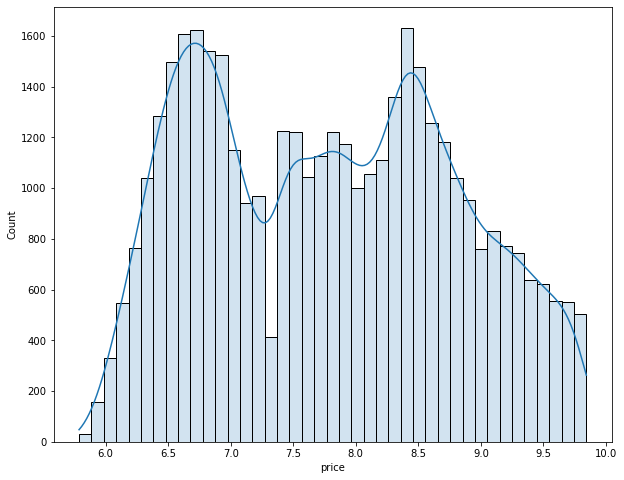

In [9]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x="price", kde=True, alpha = 0.2)

## Numerical Predictors Variables

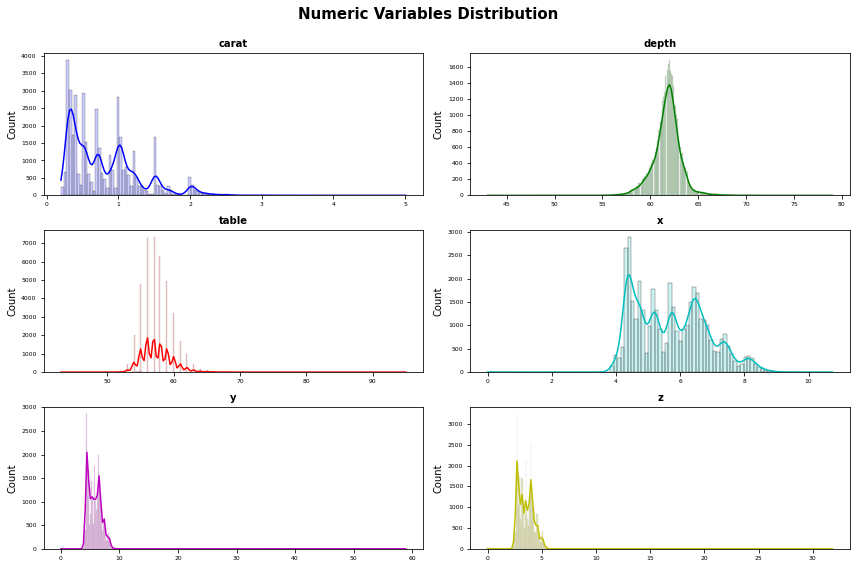

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(12, 8))
axes = axes.flat
numerical_cols = df_train.drop("price", axis=1).select_dtypes(include=["int", "float"]).columns

for ind, col in enumerate(numerical_cols):
    sns.histplot(data = df_train, 
                 x = col, 
                 color = list(mcolors.BASE_COLORS)[ind], 
                 kde=True, 
                 ax = axes[ind], 
                 alpha=0.2)
    
    axes[ind].set_title(col, fontsize = 10, fontweight = "bold")
    axes[ind].tick_params(labelsize = 6)
    axes[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle("Numeric Variables Distribution", fontsize = 15, fontweight = "bold");

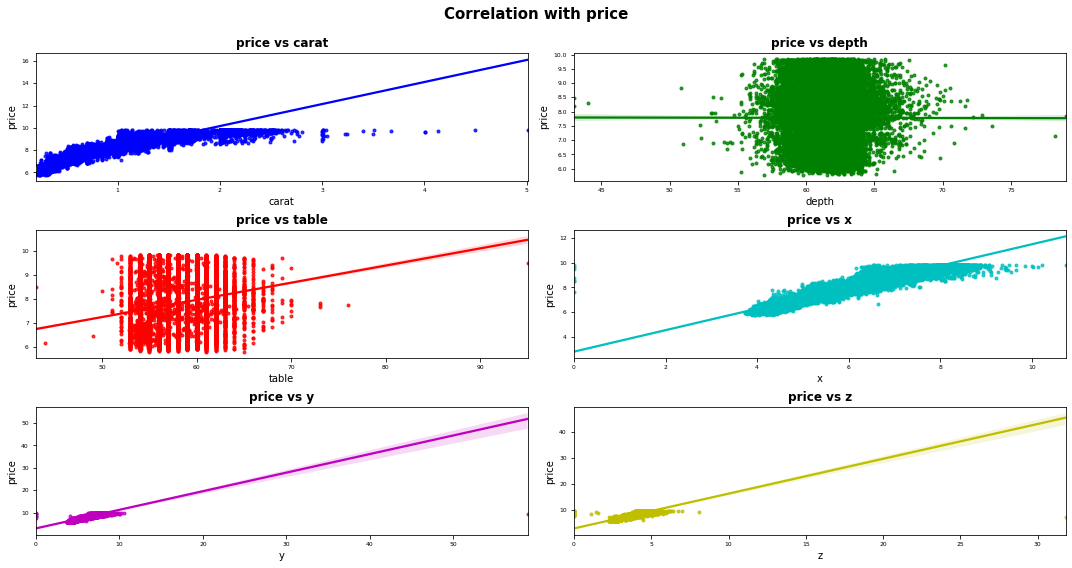

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(15,8))
axes = axes.flat
for ind, cols in enumerate(numerical_cols):
    sns.regplot(x = cols, 
                y = "price", 
                data = df_train, 
                color = list(mcolors.BASE_COLORS)[ind], 
                marker = ".", 
                ax = axes[ind])
    
    axes[ind].set_title(f"price vs {cols}", fontsize = 12, fontweight = "bold")
    axes[ind].tick_params(labelsize = 6)
    axes[ind].set_xlabel(f"{cols}")
    axes[ind].set_ylabel("price")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Correlation with price", fontsize = 15, fontweight = "bold");

In [12]:
df_train.corr()

,id,carat,depth,table,x,y,z,price
id,1.000000,-0.006196,0.001098,-0.008829,-0.007112,-0.006420,-0.007766,-0.006926
carat,-0.006196,1.000000,0.025089,0.182590,0.974516,0.950563,0.947930,0.920878
depth,0.001098,0.025089,1.000000,-0.300152,-0.028389,-0.032561,0.091421,-0.000924
table,-0.008829,0.182590,-0.300152,1.000000,0.196031,0.184322,0.150142,0.158128
x,-0.007112,0.974516,-0.028389,0.196031,1.000000,0.973617,0.965597,0.957653
y,-0.006420,0.950563,-0.032561,0.184322,0.973617,1.000000,0.945958,0.934700
z,-0.007766,0.947930,0.091421,0.150142,0.965597,0.945958,1.000000,0.930157
price,-0.006926,0.920878,-0.000924,0.158128,0.957653,0.934700,0.930157,1.000000


<AxesSubplot:>

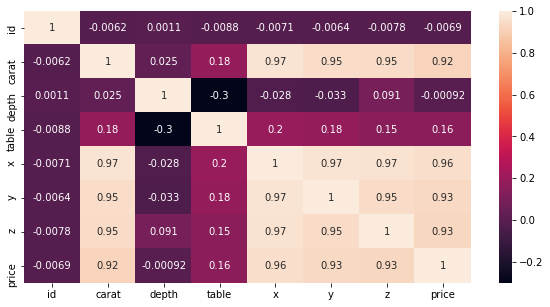

In [13]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_train.corr(), annot = True)

## Categorical Predictors Variables

Text(0.5, 0.98, 'Categorical Variables Distribution')

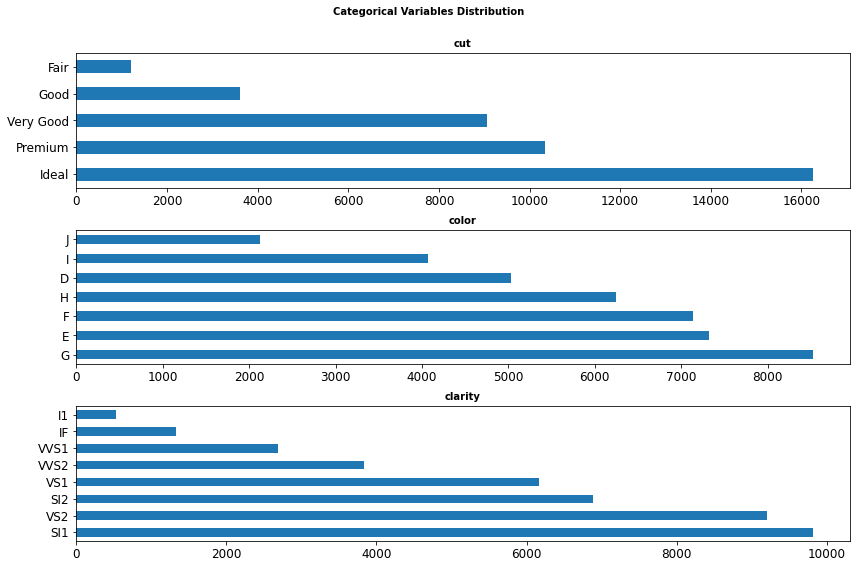

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8))
axes = axes.flat
categorical_cols = df_train.select_dtypes(include=["object"]).columns
for ind, cols in enumerate(categorical_cols):
    df_train[cols].value_counts().plot.barh(ax=axes[ind])
    axes[ind].set_title(cols, fontsize=10, fontweight="bold")
    axes[ind].tick_params(labelsize=12)
    axes[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Categorical Variables Distribution", fontsize=10, fontweight="bold")

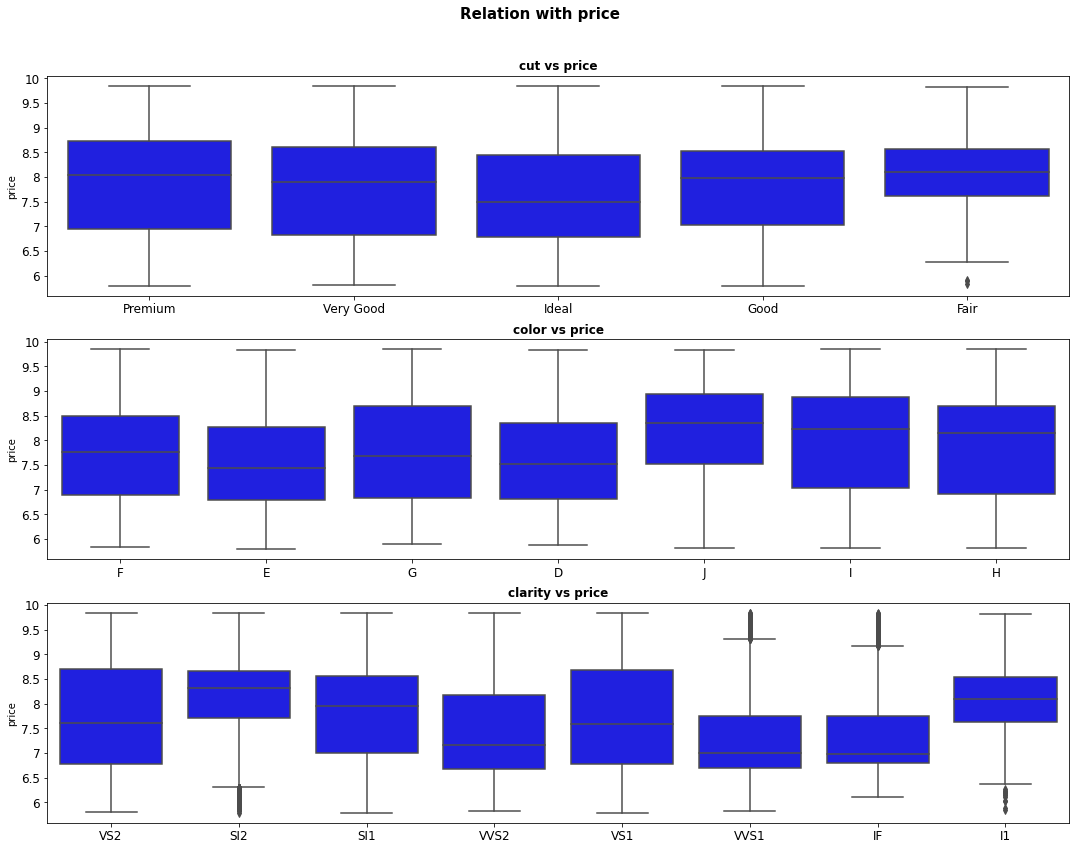

In [15]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(15,12))
axes = axes.flat
for ind, cols in enumerate(categorical_cols):
    sns.boxplot(x = cols, y="price", data=df_train, color="blue", ax=axes[ind])

    axes[ind].set_title(f"{cols} vs price", fontsize = 12, fontweight = "bold")
    axes[ind].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[ind].tick_params(labelsize = 12)
    axes[ind].set_xlabel("")
    axes[ind].set_ylabel("price")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Relation with price", fontsize = 15, fontweight = "bold");

# Preprocessing Data

## Dropping ID Variable

As a first action, we will delete the `id` column because it does not give us any relevant information about the diamonds.

In [16]:
#drop columns: id -> Useless
df_train = df_train.drop("id", axis=1)

## Dropping variable with correlation close to 0

In [17]:
#drop colums: depth -> correlation with target variable close to 0
df_train = df_train.drop("depth", axis=1)

## Encoding Categorical Variables

Now, let's check the values of the `object` type features.

In [18]:
#check uniques
df_train.clarity.unique()

array(['VS2', 'SI2', 'SI1', 'VVS2', 'VS1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [19]:
df_train.cut.unique()

array(['Premium', 'Very Good', 'Ideal', 'Good', 'Fair'], dtype=object)

In [20]:
df_train.color.unique()

array(['F', 'E', 'G', 'D', 'J', 'I', 'H'], dtype=object)

Going deeper into the diamond information, we have seen that the values of the three features (`clarity`, `cut`, and `color`) have a scale, that is, they follow an order.

Therefore, our strategy for converting these features to numerical is a hand encoding. By setting values from $1$ -> smallest value, to $n$ -> largest value.

We create dictionaries where the keys are the categorical value and the values are the numerical values that we assign to them.

In [21]:
#review diamond documentation and see that there 
#is numerical order in the categorical features. Encode the categorical features by numerical features.
encoding_cut =  {"Fair":1, "Good":2, 
          "Ideal":3, "Very Good":4, "Premium":5}
    
    
encoding_color = {'E':1,'D':2,'F':3,
             'G':4,'H':5,'I':6,
             'J':7}

encoding_clarity = {'I1':1,'SI2':2,
               'SI1':3,'VS2':4,'VS1':5,
               'VVS2':6,'VVS1':7,'IF':8}

Using the `.apply` method we apply a `lambda` function in which we change the categorical value by the numerical value to each column.

And store the numeric value in the DataFrame column to replace the values.

In [22]:
#replace categorical variables with numerical variables
df_train["cut"] = df_train["cut"].apply(lambda x: encoding_cut[x])
df_train["color"] = df_train["color"].apply(lambda x: encoding_color[x])
df_train["clarity"] = df_train["clarity"].apply(lambda x: encoding_clarity[x])

## Ols Regression

By means of `ols` we will check the influence of the variables on the target variable.

In [23]:
#Let's get the summary of the metrics.
#Set 'price' as target variable, and the rest as predictors variables. And, them, fit the model.
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + table + x + y + z",
    data=df_train).fit()
#We see the summary
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.193e+05
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:00:50   Log-Likelihood:                 6802.5
No. Observations:               40455   AIC:                        -1.359e+04
Df Residuals:                   40446   BIC:                        -1.351e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6494      0.032     52.270      0.000       1.588       1.711
carat         -0.5070      0.010    -52.120      0.000      -0.526      -0.488
cut           -0.0024      0.001     -2.373      0.018      -0.004      -0.000
color         -0.0710      0.001   -116.949      0.000      -0.072      -0.070
clarity        0.1131      0.001    167.106      0.000       0.112       0.114
table         -0.0064      0.000    -13.133      0.000      -0.007      -0.005
x              1.0443      0.006    169.131      0.000       1.032       1.056
y              0.0229      0.004      5.846      0.000       0.015       0.031
z              0.1673      0.006     29.442      0.000       0.156       0.178
==============================================================================
Omnibus:                    67709.889   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        371970329.608
Skew:                          10.614   Prob(JB):                         0.00
Kurtosis:                     472.278   Cond. No.                     1.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, the `R-squared` label has a value of `0.952`. `R-squared` is the percentage of variation of the target variable that explains its relationship with one or more predictor variables. This value is between $0$ and $1$, and the closer to $1$ the better the fit of the model to data.

We save the cleaned DataFrame in a `.csv` file.

In [24]:
#convert to .csv
df_train.to_csv("input/train_clean.csv", header=True, index=False)

# Creating Models

## Linear Regression

To begin, we will perform a linear regression model as a means of predicting the price of diamonds based on the predictor variables we saw earlier.

We set the variable `X` for the predictor variables, and the variable `y` for the target variable.

In [25]:
#take predictors variables and response variable
X = df_train.drop("price", axis=1)
y = df_train["price"]

We use the `train_test_split` method to split the `X` and `y` into a 0.8 train and a 0.2 test.

We will train the model with the 0.8 selected by the method and test it with the 0.2 of the test.

In [26]:
#split the data 0.8 traon, 0.2 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=444)

We trained the linear regression model with the 0.8 train and made predictions.

In [27]:
#select the model and put it into a variable
lr = LinearRegression()

#train model
lr.fit(X_train, y_train)

#predict y
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

We compute de mean square error with `mean_square_error` method.

In [28]:
#compute mean square error
mse_train_lr = mse(y_train, y_pred_train_lr)
mse_test_lr = mse(y_test, y_pred_test_lr)

We check the mean square error of the and of the 0.2 of the test

In [29]:
#check mean square error
mse_test_lr

0.03669954397491779

In [30]:
#check various tests
cv = RepeatedKFold(n_splits=10, n_repeats=5)
score = make_scorer(mse)
cv_scores = cross_validate(estimator=LinearRegression(), X=X, y=y, scoring=(score), cv=cv, return_train_score = True)

df_scores = pd.DataFrame(cv_scores)
df_scores

,fit_time,score_time,test_score,train_score
0,0.016959,0.003985,0.029980,0.043171
1,0.011965,0.002991,0.029209,0.043254
2,0.011938,0.001995,0.054231,0.040493
3,0.013930,0.002992,0.028008,0.043392
4,0.009974,0.002993,0.058649,0.040024
5,0.009974,0.001996,0.064296,0.041722
6,0.015957,0.001994,0.263047,0.041612
7,0.010971,0.001994,0.044773,0.041506
8,0.009974,0.002991,0.029907,0.043184
9,0.012965,0.002995,0.084815,0.037307


<AxesSubplot:xlabel='test_score', ylabel='Count'>

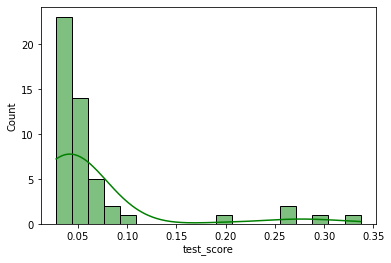

In [31]:
plt.plot(figsize=(12,8))
sns.histplot(data=df_scores["test_score"], kde=True, color="green")

In [32]:
final_df = pd.DataFrame({"Real":y_test, "Linear_Regression": y_pred_test_lr})
final_df.head()

,Real,Linear_Regression
13698,7.625,7.698620
4646,8.284,8.185732
24557,8.401,8.099830
17868,8.150,8.160598
12010,6.170,6.476773


## Random Forest Model with Hyperopt

In [33]:
params = {
        "n_estimators":hp.quniform("n_estimators", 10, 1000, 25),
        "max_depth":hp.quniform("max_depth", 4, 16, 1),
        "max_features":hp.quniform("max_features",2 ,8, 1),
        "min_samples_split":hp.quniform("min_samples_split", 2, 15, 1),
        "min_samples_leaf":hp.quniform("min_samples_leaf", 1,5,1)
}

In [34]:
def objetive(param):
    rf = RandomForestRegressor(n_estimators=int(param["n_estimators"]),
                      max_depth=int(param["max_depth"]),
                      max_features=int(param["max_features"]),
                      min_samples_split=int(param["min_samples_split"]),
                      min_samples_leaf=int(param["min_samples_leaf"]))
    
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    rmse = mse(y_test, y_pred)**(0.5)
    return {'loss':rmse, 'status': STATUS_OK }

In [35]:
trials_reg = Trials()
best = fmin(fn=objetive,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg
            )

100%|██████████| 10/10 [04:38<00:00, 27.85s/trial, best loss: 0.09303713853424071]


In [36]:
best

{'max_depth': 15.0,
 'max_features': 5.0,
 'min_samples_leaf': 1.0,
 'min_samples_split': 11.0,
 'n_estimators': 600.0}

In [37]:
rf_model = RandomForestRegressor(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    max_features=int(best["max_features"]),
    min_samples_split=int(best["min_samples_split"]),
    min_samples_leaf=int(best["min_samples_leaf"])
)

In [38]:
rf_model.fit(X_train, y_train)
y_pred_test_rf=rf_model.predict(X_test)
mse(y_test, y_pred_test_rf)

0.008666299664484437

In [39]:
final_df["RFHyperopt"] = y_pred_test_rf
final_df.head()

,Real,Linear_Regression,RFHyperopt
13698,7.625,7.698620,7.722094
4646,8.284,8.185732,8.269788
24557,8.401,8.099830,8.310144
17868,8.150,8.160598,8.043936
12010,6.170,6.476773,6.306227


## Pycaret

In [40]:
df_train[["cut", "color", "clarity"]] = df_train[["cut", "color", "clarity"]].apply(lambda x:x.astype("float64"))

In [41]:
df_train.dtypes

carat      float64
cut        float64
color      float64
clarity    float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [42]:
exp_clf101 = setup(data = df_train, target = "price", session_id=123)

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(40455, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(28318, 8)"


In [43]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0667,0.0085,0.0920,0.9917,0.0105,0.0086,0.3490
et,Extra Trees Regressor,0.0677,0.0090,0.0946,0.9913,0.0108,0.0088,3.6830
rf,Random Forest Regressor,0.0671,0.0092,0.0956,0.9911,0.0109,0.0087,4.0410
gbr,Gradient Boosting Regressor,0.0834,0.0119,0.1090,0.9884,0.0128,0.0110,1.2010
dt,Decision Tree Regressor,0.0896,0.0170,0.1302,0.9835,0.0149,0.0115,0.0780
knn,K Neighbors Regressor,0.1176,0.0262,0.1618,0.9744,0.0189,0.0155,0.1090
ada,AdaBoost Regressor,0.1569,0.0390,0.1975,0.9620,0.0232,0.0207,0.9760
ridge,Ridge Regression,0.1372,0.0849,0.2592,0.9179,0.0297,0.0177,0.0140
br,Bayesian Ridge,0.1372,0.0851,0.2593,0.9178,0.0297,0.0177,0.0190
lar,Least Angle Regression,0.1371,0.0851,0.2594,0.9177,0.0297,0.0177,0.0170


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [44]:
lgbm_reg = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0680,0.0089,0.0942,0.9914,0.0108,0.0088
1,0.0667,0.0083,0.0914,0.9917,0.0104,0.0086
2,0.0663,0.0081,0.0899,0.9921,0.0102,0.0086
3,0.0662,0.0079,0.0890,0.9924,0.0101,0.0086
4,0.0656,0.0082,0.0907,0.9921,0.0103,0.0085
5,0.0665,0.0082,0.0903,0.9920,0.0104,0.0086
6,0.0663,0.0085,0.0921,0.9918,0.0105,0.0086
7,0.0664,0.0078,0.0884,0.9926,0.0102,0.0087
8,0.0684,0.0102,0.1012,0.9896,0.0115,0.0089
9,0.0669,0.0087,0.0931,0.9915,0.0108,0.0087


In [45]:
tuned_lgbm = tune_model(lgbm_reg, search_library = "tune-sklearn", search_algorithm="hyperopt", n_iter=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0791,0.0116,0.1075,0.9888,0.0125,0.0104
1,0.0785,0.0107,0.1033,0.9894,0.0120,0.0103
2,0.0778,0.0104,0.1018,0.9899,0.0118,0.0102
3,0.0774,0.0102,0.1010,0.9902,0.0117,0.0102
4,0.0772,0.0106,0.1027,0.9899,0.0119,0.0102
5,0.0770,0.0104,0.1019,0.9899,0.0119,0.0102
6,0.0785,0.0108,0.1038,0.9896,0.0121,0.0104
7,0.0761,0.0096,0.0982,0.9908,0.0115,0.0101
8,0.0791,0.0129,0.1134,0.9870,0.0131,0.0104
9,0.0774,0.0107,0.1035,0.9894,0.0121,0.0102


In [46]:
tuned_opt_lgbm = tune_model(lgbm_reg, search_library = "tune-sklearn", search_algorithm="optuna", n_iter=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0809,0.0122,0.1106,0.9882,0.0128,0.0106
1,0.0803,0.0111,0.1052,0.9890,0.0122,0.0106
2,0.0801,0.0108,0.1041,0.9894,0.0121,0.0105
3,0.0788,0.0104,0.1019,0.9901,0.0119,0.0104
4,0.0787,0.0110,0.1047,0.9895,0.0122,0.0104
5,0.0797,0.0109,0.1042,0.9894,0.0122,0.0105
6,0.0810,0.0113,0.1063,0.9891,0.0124,0.0107
7,0.0789,0.0102,0.1012,0.9902,0.0119,0.0105
8,0.0808,0.0136,0.1166,0.9862,0.0135,0.0107
9,0.0803,0.0115,0.1071,0.9887,0.0126,0.0107


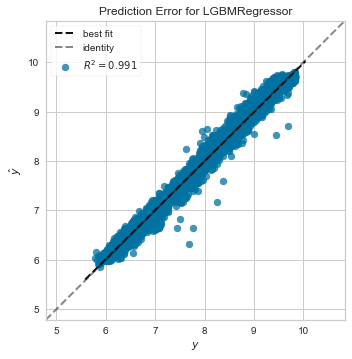

In [49]:
plot_model(lgbm_reg, plot = "error")

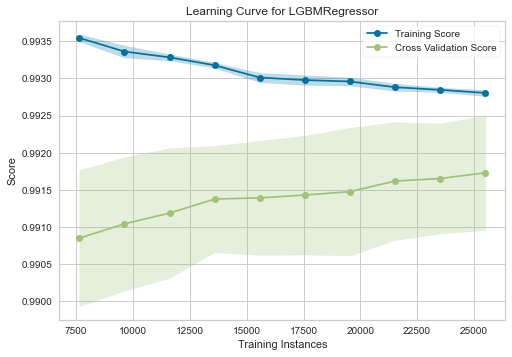

In [50]:
plot_model(lgbm_reg, plot = "learning")

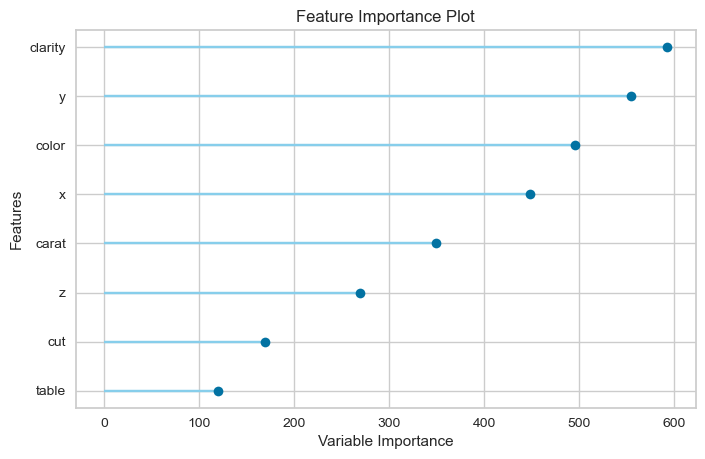

In [51]:
plot_model(lgbm_reg, plot="feature")

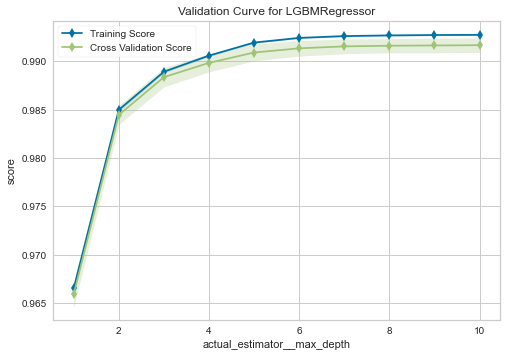

In [52]:
plot_model(lgbm_reg, plot="vc")

In [53]:
predict_model(lgbm_reg);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0672,0.0088,0.0939,0.9915,0.0107,0.0087


In [54]:
final_lgbm = finalize_model(lgbm_reg)

In [55]:
final_lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [56]:
predict_model(final_lgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0643,0.0079,0.0887,0.9924,0.0101,0.0083


In [57]:
y_pred_test_py = final_lgbm.predict(X_test)

In [58]:
mse_test_py = mse(y_test, y_pred_test_lr)

In [59]:
mse_test_py

0.03669954397491779

In [60]:
final_df["Pycaret_LGBM"] = y_pred_test_py
final_df = final_df.reset_index().drop("index", axis=1).head()

# Conclusion

In [61]:
final_df.head()

,Real,Linear_Regression,RFHyperopt,Pycaret_LGBM
0,7.625,7.698620,7.722094,7.691112
1,8.284,8.185732,8.269788,8.251302
2,8.401,8.099830,8.310144,8.367753
3,8.150,8.160598,8.043936,8.021788
4,6.170,6.476773,6.306227,6.341098


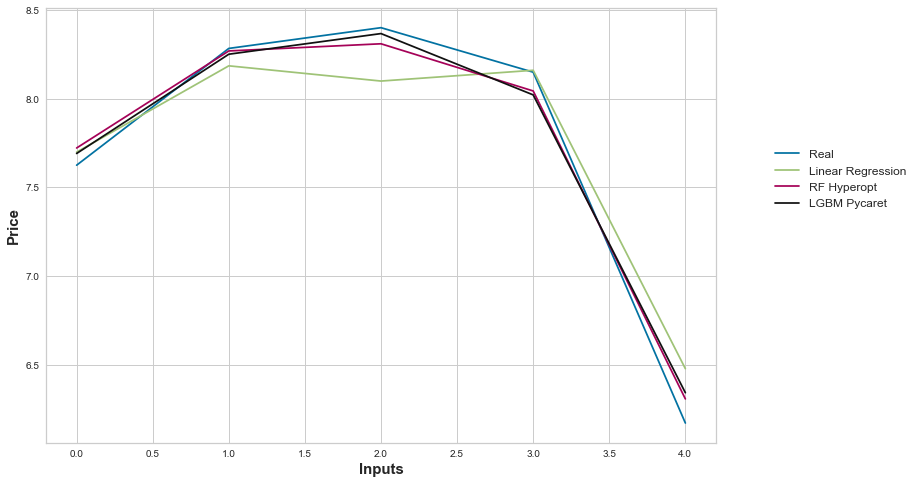

In [62]:
plt.figure(figsize=(12,8))

plt.plot(final_df.index, final_df["Real"], label = "Real", color = "b")
plt.plot(final_df.index, final_df["Linear_Regression"], label = "Linear Regression", color = "g")
plt.plot(final_df.index, final_df["RFHyperopt"], label = "RF Hyperopt", color = "m")
plt.plot(final_df.index, final_df["Pycaret_LGBM"], label = "LGBM Pycaret", color = "k")

plt.xlabel("Inputs", fontsize = 15, fontweight = "bold")
plt.ylabel("Price", fontsize = 15, fontweight = "bold")

plt.legend(loc="best", bbox_to_anchor=(1.0, 0.2, 0.3, 0.5), fontsize = 12, shadow=True)
plt.show();